In [1]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
import tensorflow_datasets as tfds

In [3]:
dataset, metadata = tfds.load('cycle_gan/monet2photo', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incomplete6OYSNA/cycle_gan-trainA.tfrecord*...:   …

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incomplete6OYSNA/cycle_gan-trainB.tfrecord*...:   …

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incomplete6OYSNA/cycle_gan-testA.tfrecord*...:   0…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incomplete6OYSNA/cycle_gan-testB.tfrecord*...:   0…

Dataset cycle_gan downloaded and prepared to ~/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [4]:
train_monet, train_photo = dataset['trainA'], dataset['trainB']

In [5]:
sample_monet = next(iter(train_monet))

In [6]:
print(sample_monet[0].numpy().shape)

(256, 256, 3)


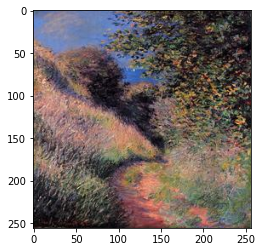

In [7]:
plt.imshow(sample_monet[0].numpy())

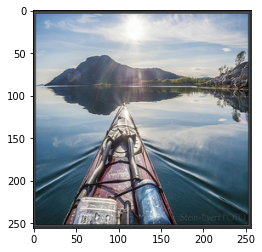

In [8]:
sample_photo = next(iter(train_photo))
plt.imshow(sample_photo[0].numpy())

In [9]:
BATCH_SIZE= 1
IMG_WIDTH= 256
IMG_HEIGHT= 256
BUFFER_SIZE= 1000

In [10]:
print(train_monet.cardinality().numpy())

1072


In [11]:
print(train_photo.cardinality().numpy())

6287


In [12]:
print(train_photo.cardinality())

tf.Tensor(6287, shape=(), dtype=int64)


In [13]:
train_monet = train_monet.map(lambda x,y:x)
train_photo = train_photo.map(lambda x,y:x)

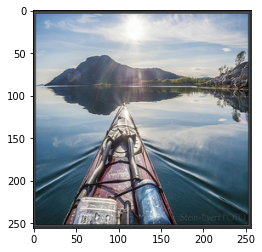

In [14]:
sample = next(iter(train_photo))
plt.imshow(sample.numpy())

In [15]:
print(sample.shape)

(256, 256, 3)


In [16]:
image_cast = tf.cast(sample, tf.float32)

In [ ]:
image_cast

In [ ]:
sample

In [19]:
image_cast = tf.image.resize(sample, [286,286], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)

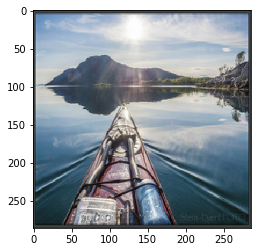

In [20]:
plt.imshow(image_cast)

In [21]:
print(image_cast.shape)

(286, 286, 3)


In [22]:
image_cast = tf.image.random_crop(image_cast, size=[IMG_HEIGHT, IMG_WIDTH,3])

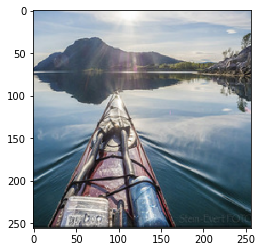

In [23]:
plt.imshow(image_cast)

In [24]:
print(image_cast.shape)

(256, 256, 3)


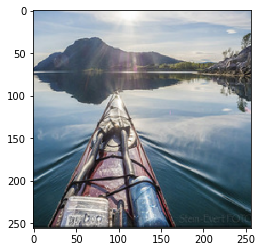

In [25]:
image_cast = tf.image.random_flip_left_right(image_cast)
plt.imshow(image_cast)

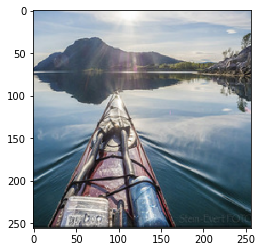

In [26]:
image_cast = tf.image.random_flip_left_right(image_cast)
plt.imshow(image_cast)

In [27]:
def normalize(image):
  image= tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image

In [28]:
def random_augment(image):
  image = tf.image.resize(image, [286,286], method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH,3])
  image = tf.image.random_flip_left_right(image)
  return image

In [29]:
def preprocess_image_train(image):
  image = random_augment(image)
  image = normalize(image)
  return image

In [30]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [31]:
train_monet = train_monet.map(preprocess_image_train, num_parallel_calls= tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
train_photo= train_photo.map(preprocess_image_train, num_parallel_calls= tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [33]:
test_monet , test_photo= dataset['testA'], dataset['testB']

In [34]:
test_monet,test_photo = test_monet.map(lambda x,y:x), test_photo.map(lambda x,y:x)

In [35]:
test_monet = test_monet.map(preprocess_image_test, num_parallel_calls= tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [36]:
test_photo = test_photo.map(preprocess_image_test, num_parallel_calls= tf.data.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

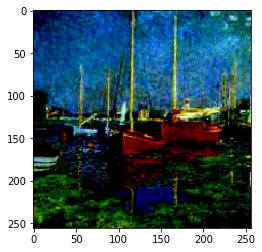

In [37]:
sample = next(iter(train_monet))
plt.imshow(sample[0])

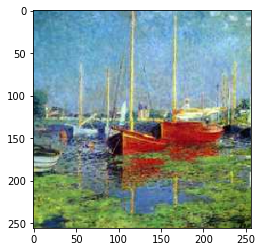

In [38]:
plt.imshow(sample[0]*0.5+0.5)

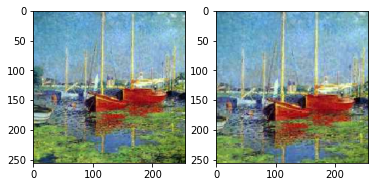

In [39]:
plt.subplot(1,2,1)
plt.imshow(sample[0]*0.5+0.5)

plt.subplot(1,2,2)
plt.imshow(random_augment(sample[0])*0.5 + 0.5)

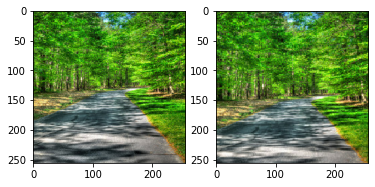

In [40]:
sample = next(iter(train_photo))

plt.subplot(1,2,1)
plt.imshow(sample[0]*0.5+0.5)

plt.subplot(1,2,2)
plt.imshow(random_augment(sample[0])*0.5 + 0.5)

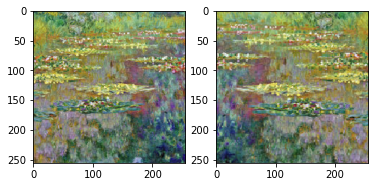

In [41]:
sample = next(iter(train_monet))

plt.subplot(1,2,1)
plt.imshow(sample[0]*0.5+0.5)

plt.subplot(1,2,2)
plt.imshow(random_augment(sample[0])*0.5 + 0.5)

In [42]:
sample.shape

TensorShape([1, 256, 256, 3])

In [43]:
print(sample[-1].shape, sample[-1:].shape)

(256, 256, 3) (1, 256, 256, 3)


In [44]:
mean, variance = tf.nn.moments(sample, axes=[1,2], keepdims=True)

In [45]:
print(mean.shape, variance.shape)

(1, 1, 1, 3) (1, 1, 1, 3)


In [46]:
print(mean.numpy(), variance.numpy(), sep='\n')

[[[[-0.04322854  0.03035796 -0.2189757 ]]]]
[[[[0.10230868 0.0784434  0.07238494]]]]


In [47]:
class InstanceNormalization(layers.Layer):
  """Instance Normalization layer"""
  def __init__(self, epsilon= 1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon= epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(name= 'scale', shape= input_shape[-1:], initializer= tf.random_normal_initializer(1, 0.02), trainable= True)
    self.offset = self.add_weight(name='offset', shape= input_shape[-1:], initializer= 'zeros', trainable= True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized= (x-mean)*inv
    return self.scale*normalized + self.offset

In [48]:
def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = keras.Sequential()
  result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))

  if apply_norm:
    result.add(InstanceNormalization())
  result.add(layers.LeakyReLU())
  return result

In [49]:
downsample(3,4)(sample).shape

TensorShape([1, 128, 128, 3])

In [50]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
  
  if apply_dropout:
    result.add(layers.Dropout(0.5))

  result.add(layers.LeakyReLU())
  return result

In [51]:
upsample(3,4)(sample).shape

TensorShape([1, 512, 512, 3])

In [52]:
def unet_generator(output_channels=3):
  down_stack=[
      downsample(64,4, apply_norm=False),
      downsample(128,4),
      downsample(256,4),
      downsample(512,4),
      downsample(512,4),
      downsample(512,4),
      downsample(512,4),
      downsample(512,4),
  ]

  up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer= initializer, activation= 'tanh')

  concat = layers.Concatenate()
  inputs= layers.Input(shape=[None, None, 3])

  x= inputs

  skips= []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])


  for up,skip in zip(up_stack, skips):
    x= up(x)
    x= concat([x, skip])

  x= last(x)

  return keras.Model(inputs= inputs, outputs= x)

In [53]:
def discriminator(target= True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp= layers.Input(shape=[None, None, 3], name='input_image')
  x= inp

  if target:
    tar = layers.Input(shape=[None, None, 3], name='target_image')
    x= layers.Concatenate([inp,tar])

  down1= downsample(64,4, apply_norm=False)(x)
  down2= downsample(128,4)(down1)
  down3= downsample(256, 4)(down2)

  zero_pad1= layers.ZeroPadding2D()(down3)

  conv= layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  norm1= InstanceNormalization()(conv)

  leaky_relu= layers.LeakyReLU()(norm1)

  zero_pad2= layers.ZeroPadding2D()(leaky_relu)

  last = layers.Conv2D(1, 4, strides= 1, kernel_initializer=initializer)(zero_pad2)

  if target:
    return keras.Model(inputs= [inp, last], outputs= last)
  else:
    return keras.Model(inputs= inp, outputs= last)

In [54]:
OUTPUT_CHANNELS= 3
generator_g= unet_generator(output_channels= OUTPUT_CHANNELS)
generator_f = unet_generator(output_channels= OUTPUT_CHANNELS)

In [55]:
discriminator_x = discriminator(target= False)
discriminator_y = discriminator(target= False)

In [56]:
sample_monet = next(iter(train_monet))
sample_photo = next(iter(train_photo))

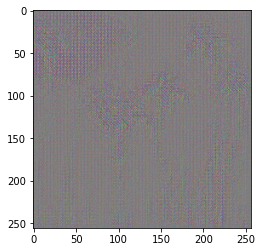

In [57]:
sample_gen_monet = generator_g(sample_monet)

plt.imshow(sample_gen_monet[0]*0.5 + 0.5)

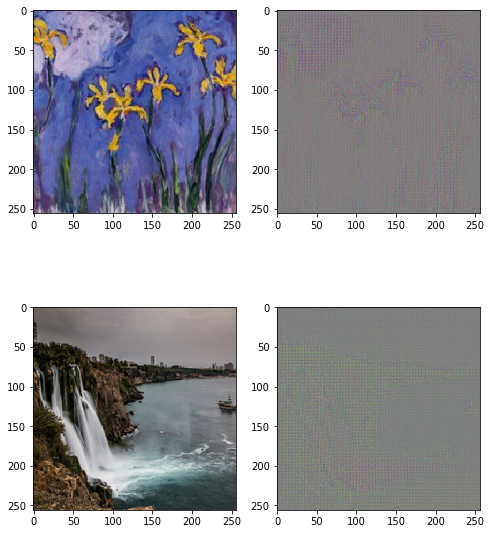

In [58]:
plt.figure(figsize=(2*4,2*5))
plt.subplot(2,2,1)
plt.imshow(sample_monet[0]*0.5+0.5)

plt.subplot(2,2,2)
plt.imshow(sample_gen_monet[0]*0.5+0.5)

sample_gen_photo = generator_f(sample_photo)

plt.subplot(2,2,3)
plt.imshow(sample_photo[0]*0.5+0.5)

plt.subplot(2,2,4)
plt.imshow(sample_gen_photo[0]*0.5+0.5)

In [59]:
discriminator_x_output = discriminator_x(sample_monet).numpy()
print(discriminator_x_output.shape, discriminator_x_output[0,...,-1].shape)

(1, 30, 30, 1) (30, 30)


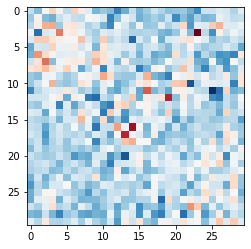

In [60]:
plt.imshow(discriminator_x_output[0,...,-1], cmap='RdBu_r')

In [61]:
cross_entropy_loss = keras.losses.BinaryCrossentropy(from_logits= True)

In [62]:
def discriminator_loss(real, generated):
  real_loss = cross_entropy_loss(tf.ones_like(real), real)
  gen_loss = cross_entropy_loss(tf.zeros_like(generated), generated)
  total_loss = real_loss + gen_loss
  return total_loss*0.5

In [63]:
def generator_loss(preds_generated):
  return cross_entropy_loss(tf.ones_like(preds_generated), preds_generated)

In [64]:
LAMBDA= 10

In [65]:
def cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image-cycled_image))
  return loss*LAMBDA

In [66]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return loss*LAMBDA*0.5

In [67]:
generator_g_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

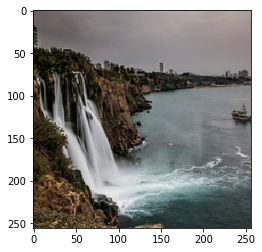

In [68]:
plt.imshow(sample_photo[0]*0.5 + 0.5)

In [69]:
def generate_images(model):
  generated_prediction = model(sample_photo)
  plt.figure(figsize=(12,12))

  titles= ['Input Image', 'Predicted Image']
  plot_images = [sample_photo[0], generated_prediction[0]]

  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(titles[i])
    plt.imshow(plot_images[i]*0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [70]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # Cycled predictions, output of cycle should be same as input provided
    # Let generator_g transform x->y , and generator_f transform y->x
    # discriminator_x takes x and classify, and discriminator_y takes y and classify

    # 1. generator_g takes x, generate fake_y, then generator_f takes fake_y and generated, cycle_x (x,cycle_x should be similar)

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training= True)

    # 2. Same cycle but starting from generator_f

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training= True)

    # 3. Case when input given to generator is same as expected output

    same_y = generator_g(real_y, training=True)
    same_x = generator_f(real_x, training= True)

    disc_pred_real_x = discriminator_x(real_x, training=True)
    disc_pred_fake_x = discriminator_x(fake_x, training=True)

    disc_pred_real_y = discriminator_y(real_y, training=True)
    disc_pred_fake_y = discriminator_y(fake_y, training=True)

    # All outputs generated, calculating lossess from these
    total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

    gen_g_identity_loss = identity_loss(real_y, same_y)
    gen_f_identity_loss = identity_loss(real_x, same_x)

    gen_g_loss = generator_loss(disc_pred_fake_y)
    gen_f_loss = generator_loss(disc_pred_fake_x)

    total_gen_g_loss = gen_g_loss + gen_g_identity_loss + total_cycle_loss
    total_gen_f_loss = gen_f_loss + gen_f_identity_loss + total_cycle_loss

    disc_x_loss = discriminator_loss(disc_pred_real_x, disc_pred_fake_x)
    disc_y_loss = discriminator_loss(disc_pred_real_y, disc_pred_fake_y)

  gen_g_grads = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  gen_f_grads = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  disc_x_grads = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  disc_y_grads = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  generator_g_optimizer.apply_gradients(zip(gen_g_grads, generator_g.trainable_variables ))
  generator_f_optimizer.apply_gradients(zip(gen_f_grads, generator_f.trainable_variables ))

  discriminator_x_optimizer.apply_gradients(zip(disc_x_grads, discriminator_x.trainable_variables ))
  discriminator_y_optimizer.apply_gradients(zip(disc_y_grads, discriminator_y.trainable_variables ))

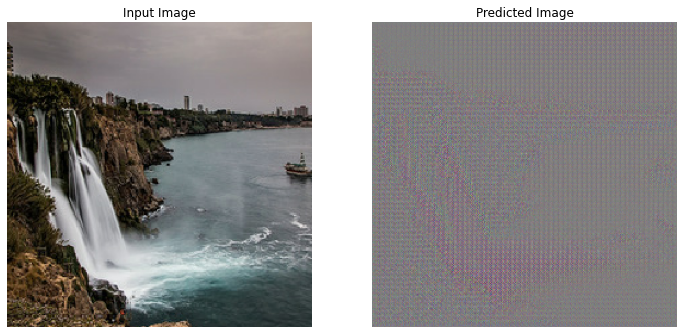

In [71]:
generate_images(generator_g)

In [72]:
from IPython.display import clear_output

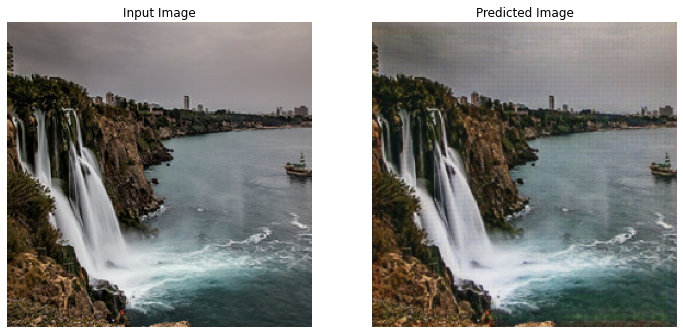

In [73]:
EPOCHS = 10
for epoch in range(EPOCHS):
  for image_x , image_y in tf.data.Dataset.zip((train_photo, train_monet)):
    train_step(image_x, image_y)

  clear_output(wait= True)
  generate_images(generator_g)  

In [78]:
def generate_images(model, photo, fig_name):
  generated_prediction = model(photo)

  images = [photo[0], generated_prediction[0]]
  titles = ["Original Image", "Generated Image"]

  plt.figure(figsize=(12,12))
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(titles[i])
    plt.imshow(images[i]*0.5+0.5)
    plt.axis('off')
  plt.savefig(fig_name)
  plt.show()

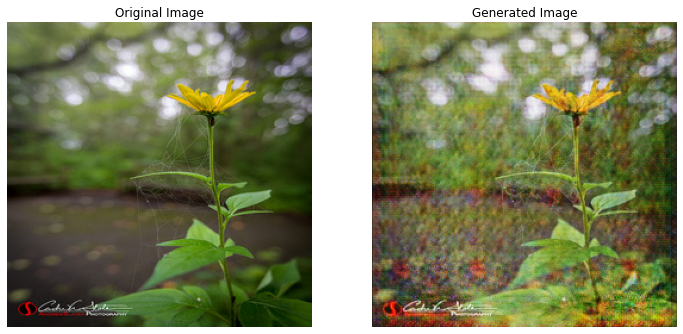

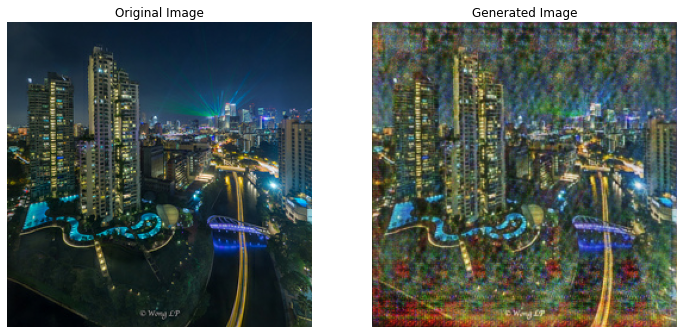

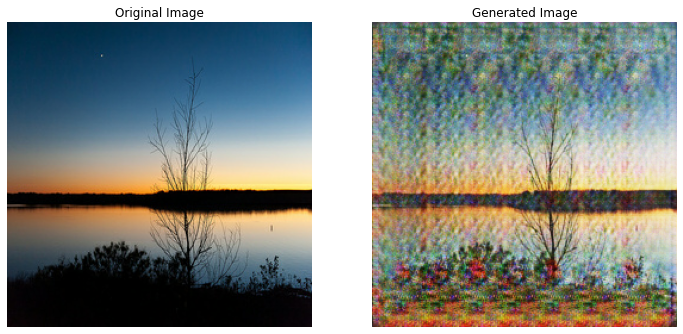

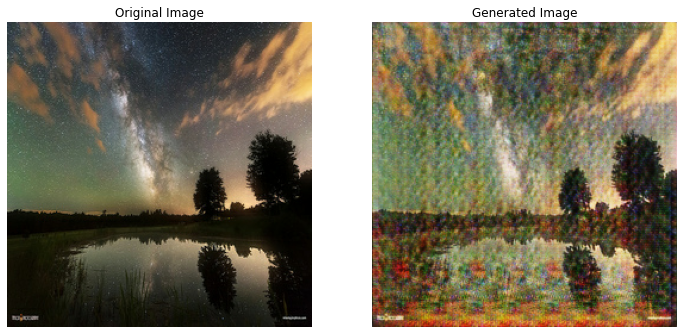

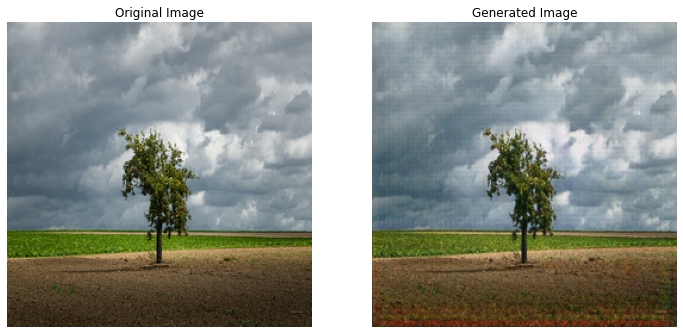

In [80]:
for img in test_photo.take(5):
  generate_images(generator_g, img, "photo_to_monet.png")

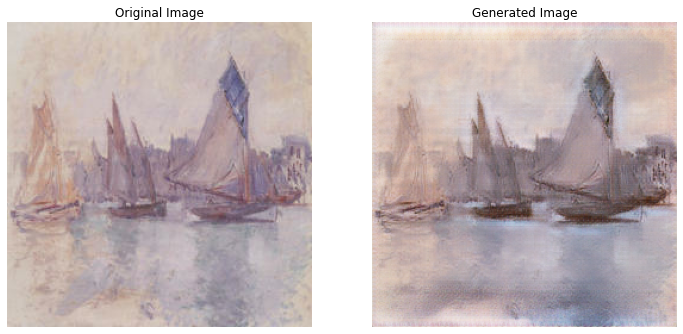

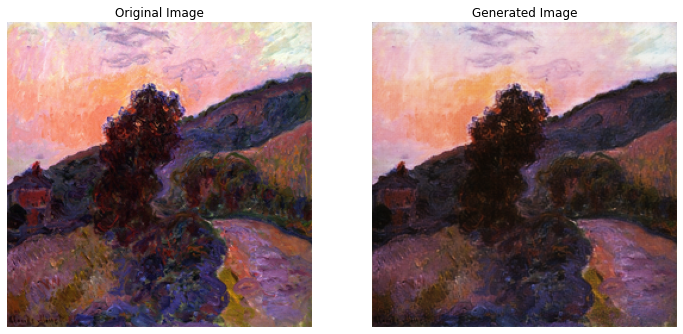

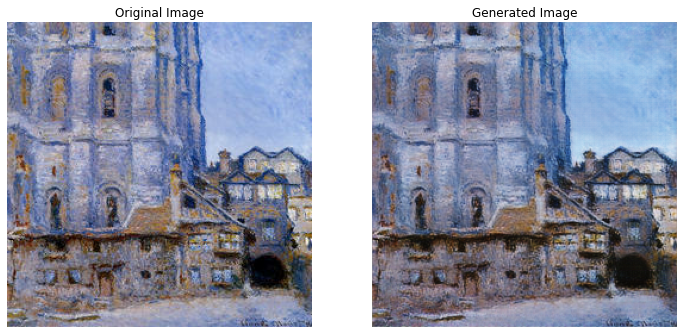

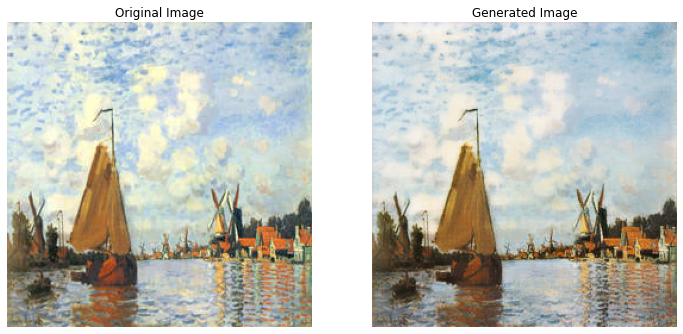

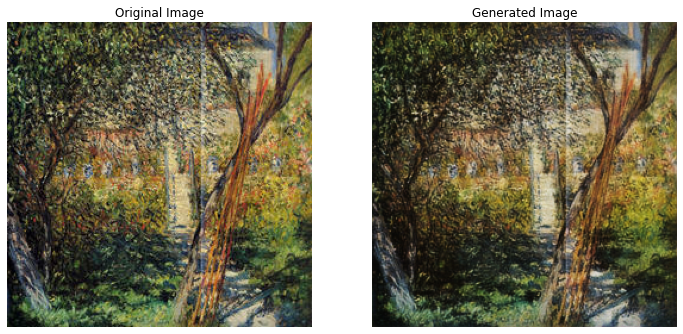

In [82]:
for img in test_monet.take(5):
  generate_images(generator_f, img, "monet_to_photo.png")